# Implementação de um modelo de Regressão Linear com Regularidade Elastic Net(L1 + L2).

* Versão Básica:

In [10]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Gerando dados artificiais:
np.random.seed(42)
X = np.random.rand(100, 5) # 100 amostras, 5 variáveis
y = 3 * X[:, 0] - 2 * X[:, 1] + np.random.randn(100) * 0.1 # só X0 e X1 influenciam

# Separando treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando e treinando o modelo Elastic Net:
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

# alpha controla a força total da regularização
# l1_ratio controla o equilíbrio entre L1 e L2:
#     l1_ratio = 1 → Lasso
#     l1_ratio = 0 → Ridge

elastic.fit(X_train, y_train)

# Fazendo previsões:
y_pred = elastic.predict(X_test)

# Avaliando o modelo:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Coeficientes:", elastic.coef_)
print("Intercepto:", elastic.intercept_)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Coeficientes: [ 1.62598099 -1.03807265 -0.          0.         -0.        ]
Intercepto: 0.2103235510977841
MAE: 0.4734
RMSE: 0.5689
R²: 0.7606


* Versão Robusta:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1. Dados mais realistas para demonstrar o poder do Elastic Net:
np.random.seed(42)
n_samples = 500
n_features = 20

# Criar dataset com:
# - Grupos de features correlacionadas
# - Features irrelevantes
# - Relação não-linear implícita

X = np.random.randn(n_samples, n_features)

# Introduzir correlações (cenário real onde Elastic Net brilha):
X[:, 1] = X[:, 0] * 0.8 + np.random.randn(n_samples) * 0.2 # X1 correlacionada com X0
X[:, 3] = X[:, 2] * 0.7 + np.random.randn(n_samples) * 0.3 # X3 correlacionada com X2
X[:, 5] = X[:, 4] * 0.6 + np.random.randn(n_samples) * 0.4 # X5 correlacionada com X4

# Coeficientes verdadeiros - grupos correlacionados são importantes:
true_beta = np.zeros(n_features)
true_beta[[0, 1]] = [2.5, -1.8] # Grupo 1 (correlacionado)
true_beta[[2, 3]] = [1.5, -1.2] # Grupo 2 (correlacionado)
true_beta[6] = 1.0 # Feature individual importante
true_beta[8] = -0.8 # Feature individual importante

y = X.dot(true_beta) + np.random.randn(n_samples) * 0.3

print("=== ANÁLISE EXPLORATÓRIA ===")
print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} features")
print(f"Features importantes: {np.where(true_beta != 0)[0]}")
print(f"Grupos correlacionados: (0,1), (2,3), (4,5)")

=== ANÁLISE EXPLORATÓRIA ===
Dataset: 500 amostras, 20 features
Features importantes: [0 1 2 3 6 8]
Grupos correlacionados: (0,1), (2,3), (4,5)


In [5]:
# 2. Divisão treino-teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 3. Pipeline profissional com padronização (CRUCIAL para Elastic Net):
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Importante: Elastic Net é sensível à escala
    ('elastic', ElasticNet(random_state=42, max_iter=10000))
])

# 4. Busca automática dos melhores hiperparâmetros:
print("\n=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===")

# Método ElasticNetCV (mais eficiente):
elastic_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99], # Amplo range de l1_ratio
    alphas=np.logspace(-3, 1, 50), # Amplo range de alpha
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1 
)

elastic_cv.fit(X_train, y_train)
print(f"Melhores parâmetros (ElasticNetCV):")
print(f"  Alpha: {elastic_cv.alpha_:.6f}")
print(f"  L1 Ratio: {elastic_cv.l1_ratio_:.3f}")


=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===
Melhores parâmetros (ElasticNetCV):
  Alpha: 0.001456
  L1 Ratio: 0.990


In [6]:
# 5. Modelo final com os melhores parâmetros:
final_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(
        alpha=elastic_cv.alpha_,
        l1_ratio=elastic_cv.l1_ratio_,
        max_iter=10000,
        random_state=42
    ))
])

final_elastic.fit(X_train, y_train)

# 6. Previsões:
y_pred_train = final_elastic.predict(X_train)
y_pred_test = final_elastic.predict(X_test)

# 7. Avaliação completa:
def avaliacao_abrangente(y_true, y_pred, set_name):
    """Avaliação detalhada do modelo"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

    print(f"\n{set_name}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}") 
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

print("=== AVALIAÇÃO DO MODELO ===")
metrics_train = avaliacao_abrangente(y_train, y_pred_train, "TREINO")
metrics_test = avaliacao_abrangente(y_test, y_pred_test, "TESTE")

=== AVALIAÇÃO DO MODELO ===

TREINO:
  MAE:  0.2480
  MSE:  0.0969
  RMSE: 0.3113
  R²:   0.9749
  MAPE: 317.76%

TESTE:
  MAE:  0.2515
  MSE:  0.0939
  RMSE: 0.3064
  R²:   0.9746
  MAPE: 61.35%


In [7]:
# 8. Análise de overfitting:
overfit_gap = metrics_train['R²'] - metrics_test['R²']
print(f"\n=== ANÁLISE DE OVERFITTING ===")
print(f"Diferença R² (Treino - Teste): {overfit_gap:.4f}")

if overfit_gap > 0.1:
    print("⚠️  ALERTA: Possível overfitting!")
elif overfit_gap < 0.05:
    print("✅ Modelo generalizando bem!")
else:
    print("📊 Modelo com generalização moderada")


=== ANÁLISE DE OVERFITTING ===
Diferença R² (Treino - Teste): 0.0003
✅ Modelo generalizando bem!


In [8]:
# 9. Análise detalhada dos coeficientes:
elastic_model = final_elastic.named_steps['elastic']
coeficientes = elastic_model.coef_

print(f"\n=== ANÁLISE DOS COEFICIENTES ===")
print(f"Intercepto: {elastic_model.intercept_:.4f}")
print(f"Features selecionadas: {np.sum(coeficientes != 0)}/{n_features}")

# Tabela detalhada:
coef_analise = []
for i in range(n_features):
    coef_analise.append({
        'Feature': f'X{i}',
        'Coeficientes': coeficientes[i],
        'Verdadeiro': true_beta[i],
        'Selecionados': coeficientes[i] != 0,
        'Importante': true_beta[i] != 0,
        'Grupo': f"({i//2*2},{i//2*2+1})" if i % 2 == 0 and i < 6 else "Individual"
    })

coef_df = pd.DataFrame(coef_analise)
print(f"\nCoeficientes detalhados:")
display(coef_df.round(4))


=== ANÁLISE DOS COEFICIENTES ===
Intercepto: -0.0939
Features selecionadas: 19/20

Coeficientes detalhados:


,Feature,Coeficientes,Verdadeiro,Selecionados,Importante,Grupo
0,X0,2.5400,2.5,True,True,"(0,1)"
1,X1,-1.4898,-1.8,True,True,Individual
2,X2,1.4367,1.5,True,True,"(2,3)"
3,X3,-0.8344,-1.2,True,True,Individual
4,X4,-0.0068,0.0,True,False,"(4,5)"
5,X5,-0.0093,0.0,True,False,Individual
6,X6,1.0460,1.0,True,True,Individual
7,X7,-0.0037,0.0,True,False,Individual
8,X8,-0.7655,-0.8,True,True,Individual
9,X9,-0.0007,0.0,True,False,Individual


In [9]:
# 10. Métricas de seleção de features:
true_positivos = np.sum((coeficientes != 0) & (true_beta != 0))
false_positivos = np.sum((coeficientes != 0) & (true_beta ==0))
false_negativos = np.sum((coeficientes == 0) & (true_beta != 0))

print(f"\n=== MÉTRICAS DE SELEÇÃO ===")
print(f"True Positives:  {true_positivos}")
print(f"False Positives: {false_positivos}")
print(f"False Negatives: {false_negativos}")

if (true_positivos + false_positivos) > 0:
    precision = true_positivos / (true_positivos + false_positivos)
    recall = true_positivos / (true_positivos + false_negativos)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precisão: {precision:.1%}")
    print(f"Recall:    {recall:.1%}")
    print(f"F1-Score:  {f1:.1%}")



=== MÉTRICAS DE SELEÇÃO ===
True Positives:  6
False Positives: 13
False Negatives: 0
Precisão: 31.6%
Recall:    100.0%
F1-Score:  48.0%


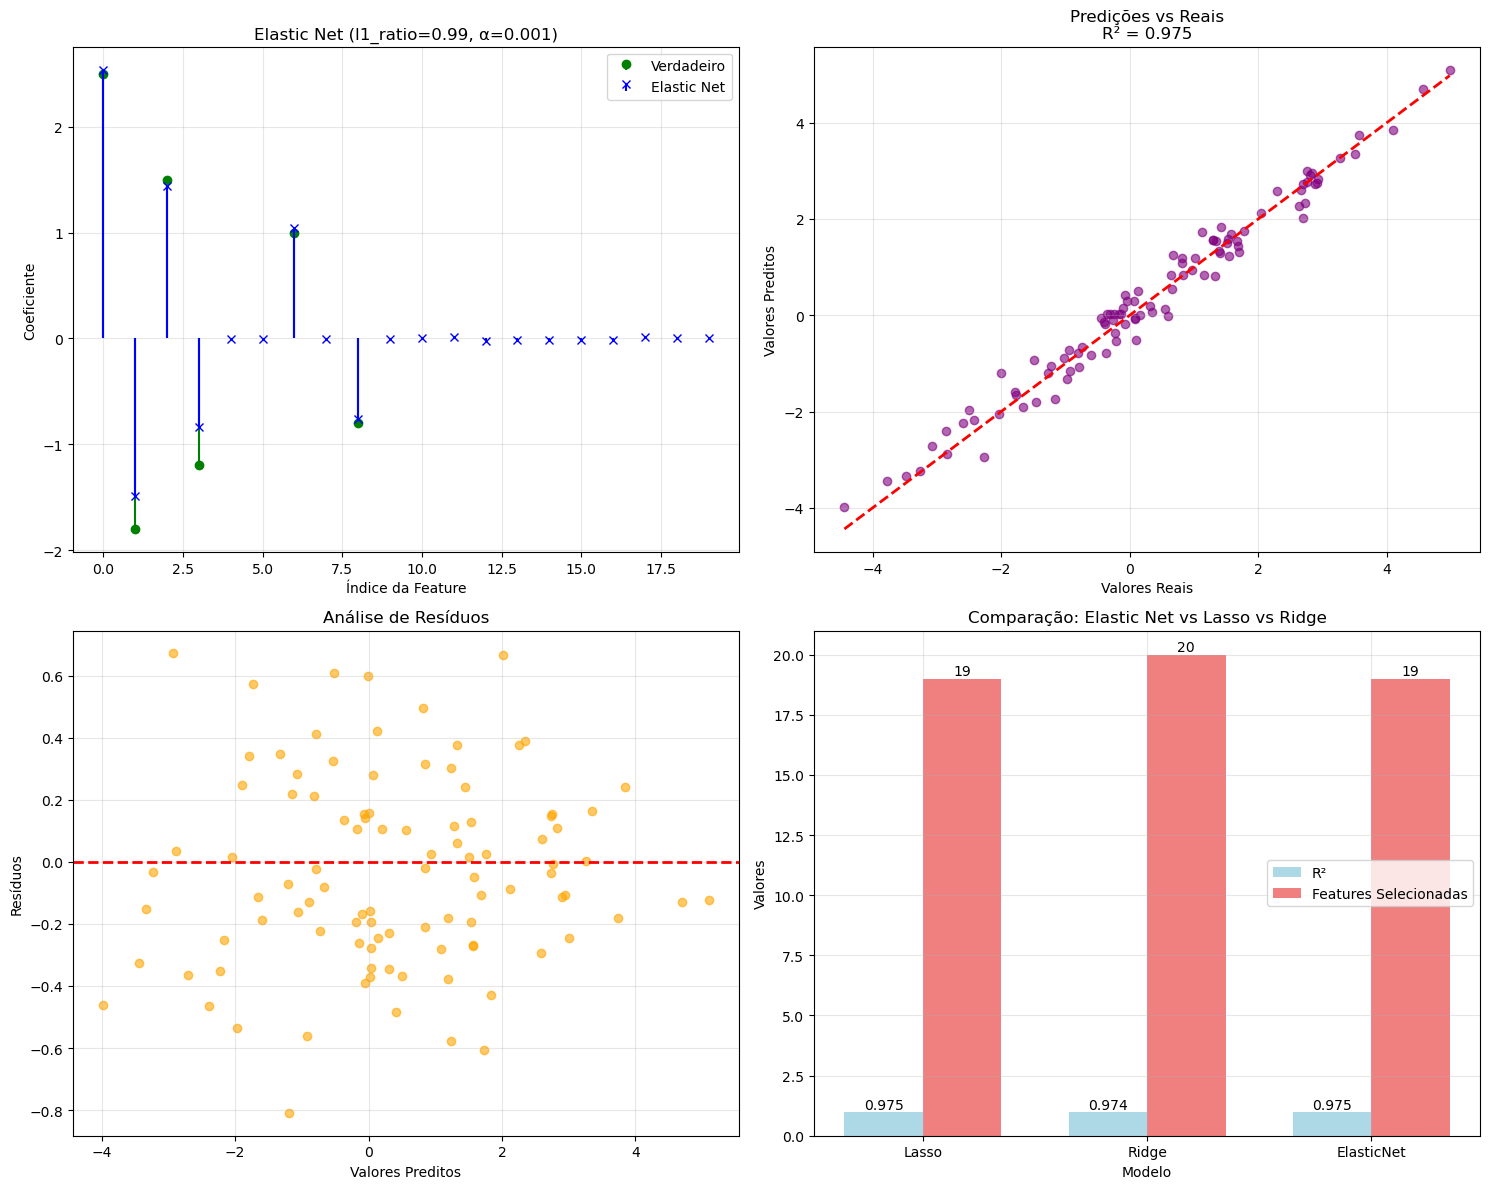

In [11]:
# 11. Visualizações profissionais:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Coeficientes Elastic Net vs Verdadeiros:
axes[0, 0].stem(np.where(true_beta != 0)[0], true_beta[true_beta != 0],
                linefmt='g-', markerfmt='go', basefmt=" ", label='Verdadeiro')
axes[0, 0].stem(range(n_features), coeficientes,
                linefmt='b-', markerfmt='bx', basefmt=" ", label='Elastic Net')
axes[0, 0].set_xlabel('Índice da Feature')
axes[0, 0].set_ylabel('Coeficiente')
axes[0, 0].set_title(f'Elastic Net (l1_ratio={elastic_cv.l1_ratio_:.2f}, α={elastic_cv.alpha_:.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Predições vs Reais:
axes[0, 1].scatter(y_test, y_pred_test, alpha=0.6, color='purple')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', linewidth=2)
axes[0, 1].set_xlabel('Valores Reais')
axes[0, 1].set_ylabel('Valores Preditos')
axes[0, 1].set_title(f'Predições vs Reais\nR² = {metrics_test["R²"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Resíduos:
residuals = y_test - y_pred_test
axes[1, 0].scatter(y_pred_test, residuals, alpha=0.6, color='orange')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Valores Preditos')
axes[1, 0].set_ylabel('Resíduos')
axes[1, 0].set_title('Análise de Resíduos')
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Comparação com Lasso e Ridge:
comparacao_modelos = {
    'Lasso': Lasso(alpha=elastic_cv.alpha_, max_iter=10000),
    'Ridge': Ridge(alpha=elastic_cv.alpha_),
    'ElasticNet': ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, max_iter=10000)
}

# Pipeline para comparação:
resultado_comparacao = {}
for name, model in comparacao_modelos.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    n_selected = np.sum(pipeline.named_steps['model'].coef_ != 0)
    resultado_comparacao[name] = {'r2': r2, 'n_selected': n_selected}

names = list(resultado_comparacao.keys())
r2_scores = [resultado_comparacao[name]['r2'] for name in names]
n_selected = [resultado_comparacao[name]['n_selected'] for name in names]

x_pos = np.arange(len(names))
width = 0.35

bars1 = axes[1, 1].bar(x_pos - width/2, r2_scores, width, label='R²', color='lightblue')
bars2 = axes[1, 1].bar(x_pos + width/2, n_selected, width, label='Features Selecionadas', color='lightcoral')

axes[1, 1].set_xlabel('Modelo')
axes[1, 1].set_ylabel('Valores')
axes[1, 1].set_title('Comparação: Elastic Net vs Lasso vs Ridge')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars1, r2_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

for bar, value in zip(bars2, n_selected):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# 12. Validação cruzada adicional:

print("\n=== VALIDAÇÃO CRUZADA ADICIONAL ===")
cv_scores = cross_val_score(final_elastic, X_train, y_train, cv=5, scoring='r2')
print(f"Scores CV: {[f'{score:.3f}' for score in cv_scores]}")
print(f"R² CV: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")


=== VALIDAÇÃO CRUZADA ADICIONAL ===
Scores CV: ['0.964', '0.973', '0.973', '0.979', '0.967']
R² CV: 0.971 (±0.011)


In [14]:
# 13. Resumo executivo:
print("\n" + "="*70)
print("RESUMO EXECUTIVO - ELASTIC NET")
print("="*70)
print(f"• Performance: R² = {metrics_test['R²']:.3f}, RMSE = {metrics_test['RMSE']:.3f}")
print(f"• Regularização: α = {elastic_cv.alpha_:.4f}, L1 Ratio = {elastic_cv.l1_ratio_:.2f}")
print(f"• Features: {np.sum(coeficientes != 0)} selecionadas de {n_features}")
print(f"• Seleção: {true_positivos} TP, {false_positivos} FP, {false_negativos} FN")
print(f"• Generalização: {'EXCELENTE' if overfit_gap < 0.05 else 'BOA' if overfit_gap < 0.1 else 'MODERADA'}")
print("="*70)


RESUMO EXECUTIVO - ELASTIC NET
• Performance: R² = 0.975, RMSE = 0.306
• Regularização: α = 0.0015, L1 Ratio = 0.99
• Features: 19 selecionadas de 20
• Seleção: 6 TP, 13 FP, 0 FN
• Generalização: EXCELENTE
